# Paddy Prediction

## Header and Imports

In [17]:
import os
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, mean_absolute_error, mean_squared_error
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models, regularizers, Input
from tensorflow.keras.callbacks import EarlyStopping
from keras_cv.layers import RandomZoom, RandomBrightness, RandomChoice

#### Kaggle specific prefix for input file paths
- Don't need to run the cell below if running on other environments

In [193]:
KAGGLE_IN = '/kaggle/input/paddy-dataset/'

#### Constants
- Remember to fix paths if training on other environments

In [194]:
CSV_PATH = os.path.join(KAGGLE_IN, 'meta_train.csv')
IMAGE_DIR = os.path.join(KAGGLE_IN, 'train_images/train_images')
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 30

#### Load data

In [195]:
data = pd.read_csv(CSV_PATH)
data['path'] = data.apply(lambda row: os.path.join(IMAGE_DIR, row['label'], row['image_id']), axis=1)
print(data)

         image_id                  label variety  age  \
0      100330.jpg  bacterial_leaf_blight   ADT45   45   
1      100365.jpg  bacterial_leaf_blight   ADT45   45   
2      100382.jpg  bacterial_leaf_blight   ADT45   45   
3      100632.jpg  bacterial_leaf_blight   ADT45   45   
4      101918.jpg  bacterial_leaf_blight   ADT45   45   
...           ...                    ...     ...  ...   
10402  107607.jpg                 tungro   Zonal   55   
10403  107811.jpg                 tungro   Zonal   55   
10404  108547.jpg                 tungro   Zonal   55   
10405  110245.jpg                 tungro   Zonal   55   
10406  110381.jpg                 tungro   Zonal   55   

                                                    path  
0      /kaggle/input/paddy-dataset/train_images/train...  
1      /kaggle/input/paddy-dataset/train_images/train...  
2      /kaggle/input/paddy-dataset/train_images/train...  
3      /kaggle/input/paddy-dataset/train_images/train...  
4      /kaggle/input

## EDA

In [196]:
def count_parameters(df, column_name):
    total_count = len(df[column_name])
    unique_counts = df[column_name].value_counts()
    return total_count, unique_counts

In [197]:
_, label_counts = count_parameters(data, 'label')
_, variety_counts = count_parameters(data, 'variety')

print("Label Distribution:\n", label_counts)
print("\nVariety Distribution:\n", variety_counts)

# Show unique labels/varieties
print("\nUnique disease labels:", data['label'].unique())
print("\nUnique varieties:", data['variety'].unique())

Label Distribution:
 label
normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: count, dtype: int64

Variety Distribution:
 variety
ADT45             6992
KarnatakaPonni     988
Ponni              657
AtchayaPonni       461
Zonal              399
AndraPonni         377
Onthanel           351
IR20               114
RR                  36
Surya               32
Name: count, dtype: int64

Unique disease labels: ['bacterial_leaf_blight' 'bacterial_leaf_streak'
 'bacterial_panicle_blight' 'blast' 'brown_spot' 'dead_heart'
 'downy_mildew' 'hispa' 'normal' 'tungro']

Unique varieties: ['ADT45' 'IR20' 'KarnatakaPonni' 'Onthanel' 'Ponni' 'Surya' 'Zonal'
 'AndraPonni' 'AtchayaPonni' 'RR']


In [198]:
# Show missing values per column
print("Missing values in each column:")
print(data.isnull().sum())

Missing values in each column:
image_id    0
label       0
variety     0
age         0
path        0
dtype: int64


In [199]:
# Check for negative ages
invalid_ages = data[data['age'] < 0]
print(f"\nNumber of records with negative ages: {len(invalid_ages)}")
if not invalid_ages.empty:
    print(invalid_ages[['image_id', 'age', 'label', 'variety']])


Number of records with negative ages: 0


In [200]:
# Show basic stats for age
print("\nAge column statistics:")
print(data['age'].describe())


Age column statistics:
count    10407.000000
mean        64.043624
std          8.958830
min         45.000000
25%         60.000000
50%         67.000000
75%         70.000000
max         82.000000
Name: age, dtype: float64


- So far the data looks normal

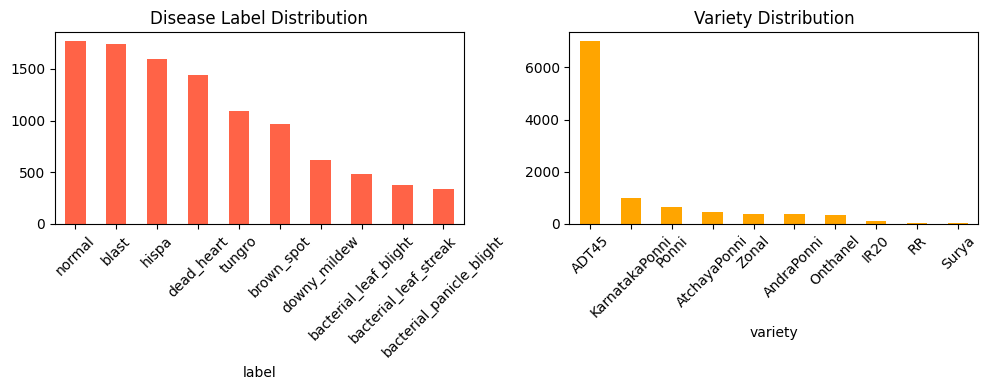

In [201]:
# Count Plots for Labels and Varieties
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
data['label'].value_counts().plot(kind='bar', title='Disease Label Distribution', color='tomato')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
data['variety'].value_counts().plot(kind='bar', title='Variety Distribution', color='orange')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

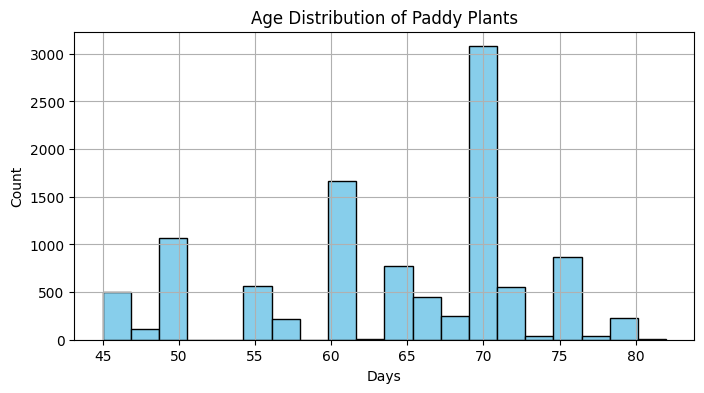

In [202]:
# Visualize Age Distribution
plt.figure(figsize=(8, 4))
plt.hist(data['age'], bins=20, color='skyblue', edgecolor='black')
plt.title("Age Distribution of Paddy Plants")
plt.xlabel("Days")
plt.ylabel("Count")
plt.grid(True)
plt.show()

## Data Preprocessing

**Use Label Encoder for both disease and variety because these 2 values are 10-classes classification**

In [203]:
disease_encoder = LabelEncoder()
variety_encoder = LabelEncoder()

data['label_enc'] = disease_encoder.fit_transform(data['label'])
data['variety_enc'] = variety_encoder.fit_transform(data['variety'])

In [11]:
# Function to load images
def load_images(paths):
    images = []
    for path in tqdm(paths, desc="Loading images"):
        img = load_img(path, target_size=IMG_SIZE)
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
    return np.array(images)

In [205]:
X = load_images(data['path'])
y_disease = data['label_enc'].values
y_variety = data['variety_enc'].values
y_age = data['age'].values

Loading images: 100%|██████████| 10407/10407 [00:28<00:00, 359.97it/s]


In [206]:
# Function to perform 90/5/5 split
def split_data(X, y, stratify=None):
    # Step 1: Split into 90% train, 10% temp
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.10, stratify=stratify, random_state=42
    )

    # Step 2: Split temp into 5% val and 5% test
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp if stratify is not None else None, random_state=42
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

In [207]:
# Split for disease classification
X_d_train, X_d_val, X_d_test, y_d_train, y_d_val, y_d_test = split_data(X, y_disease, stratify=y_disease)

# Split for variety classification
X_v_train, X_v_val, X_v_test, y_v_train, y_v_val, y_v_test = split_data(X, y_variety, stratify=y_variety)

# Split for age regression (no stratify)
X_a_train, X_a_val, X_a_test, y_a_train, y_a_val, y_a_test = split_data(X, y_age)

## Building the Model

In [208]:
# ResNet-like Architecture
# Build residual block
def residual_block(x, filters, reg_lambda):
    shortcut = x
    if x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same',
                                 kernel_regularizer=regularizers.l2(reg_lambda))(shortcut)

    x = layers.Conv2D(filters, (3, 3), padding='same',
                      kernel_regularizer=regularizers.l2(reg_lambda))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, (3, 3), padding='same',
                      kernel_regularizer=regularizers.l2(reg_lambda))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

# Bulid model from residual blocks
def build_resnet_model(input_shape=(128, 128, 3), num_outputs=10, reg_lambda=1e-4, is_regression=False):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(16, (3, 3), padding='same',
                      kernel_regularizer=regularizers.l2(reg_lambda))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = residual_block(x, filters=16, reg_lambda=reg_lambda)
    x = layers.MaxPooling2D((2, 2))(x)

    x = residual_block(x, filters=32, reg_lambda=reg_lambda)
    x = layers.MaxPooling2D((2, 2))(x)

    x = residual_block(x, filters=64, reg_lambda=reg_lambda)
    x = layers.MaxPooling2D()(x)

    x = residual_block(x, filters=128, reg_lambda=reg_lambda)
    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)

    if is_regression:
        outputs = layers.Dense(1)(x)
        loss = 'mse'
        metrics = ['mae']
    else:
        outputs = layers.Dense(num_outputs, activation='softmax')(x)
        loss = 'sparse_categorical_crossentropy'
        metrics = ['accuracy']

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss=loss, metrics=metrics)
    return model

In [209]:
# Image augmentation layer: randomly applies one of the augmentations
augmenter = RandomChoice(layers=[
    RandomZoom(height_factor=0.01, width_factor=0.01),
    RandomBrightness(factor=0.01)
])

# Final augment function to apply during dataset mapping
def augment(image, label):
    image = augmenter(image)
    return image, label

In [210]:
# Early stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

In [211]:
#define learning rate schedule
def lr_schedule(epoch):
    if epoch < 4:#start the training with high learning rate, for it to quickly capture key feature
        return 1e-3
    else: # then lower leanring rate, make the model train slower but trully capture required feature
        return 1e-4

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

## Train models

### Train disease classification model

In [212]:
# Disease class weights
disease_classes = np.unique(y_d_train)
disease_class_weights = compute_class_weight(class_weight='balanced', classes=disease_classes, y=y_d_train)
disease_class_weights_dict = dict(zip(disease_classes, disease_class_weights))
print("Disease class weights:", disease_class_weights_dict)

Disease class weights: {0: 2.1730858468677496, 1: 2.73859649122807, 2: 3.091089108910891, 3: 0.5988491048593351, 4: 1.0790322580645162, 5: 0.7215716486902928, 6: 1.678494623655914, 7: 0.6526829268292683, 8: 0.5897984886649874, 9: 0.9566905005107252}


In [213]:
# Dataset
# train_disease_ds = tf.data.Dataset.from_tensor_slices((X_d_train, y_d_train)).map(augment).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_disease_ds = tf.data.Dataset.from_tensor_slices((X_d_train, y_d_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_disease_ds = tf.data.Dataset.from_tensor_slices((X_d_val, y_d_val)).batch(BATCH_SIZE)

In [214]:
# Build and train model
model_disease = build_resnet_model(num_outputs=len(disease_encoder.classes_))
model_disease.fit(
    train_disease_ds,
    validation_data=val_disease_ds,
    epochs=EPOCHS,
    class_weight=disease_class_weights_dict,
    callbacks = [early_stop, lr_callback]
)

Epoch 1/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 26s 35ms/step - accuracy: 0.1504 - loss: 2.6338 - val_accuracy: 0.1481 - val_loss: 2.3993 - learning_rate: 0.0010
Epoch 2/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2561 - loss: 1.9821 - val_accuracy: 0.4000 - val_loss: 1.9183 - learning_rate: 0.0010
Epoch 3/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3585 - loss: 1.7443 - val_accuracy: 0.4462 - val_loss: 1.6971 - learning_rate: 0.0010
Epoch 4/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4536 - loss: 1.5411 - val_accuracy: 0.5442 - val_loss: 1.4991 - learning_rate: 0.0010
Epoch 5/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5685 - loss: 1.2412 - val_accuracy: 0.7058 - val_loss: 1.0088 - learning_rate: 1.0000e-04
Epoch 6/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6188 - loss: 1.0727 - val_accuracy: 0.7327 - val_loss: 0.9231 - learning_rate: 1.0000e-04
Epoch 7/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6453 -

#### Train variety classification model

In [215]:
# Variety class weights
variety_classes = np.unique(y_v_train)
variety_class_weights = compute_class_weight(class_weight='balanced', classes=variety_classes, y=y_v_train)
variety_class_weights_dict = dict(zip(variety_classes, variety_class_weights))
print("Variety class weights:", variety_class_weights_dict)

Variety class weights: {0: 0.14883203559510566, 1: 2.7628318584070795, 2: 2.256867469879518, 3: 9.093203883495146, 4: 1.0535433070866143, 5: 2.963924050632911, 6: 1.5847715736040608, 7: 29.26875, 8: 32.296551724137935, 9: 2.6089136490250695}


In [216]:
# Dataset
# train_variety_ds = tf.data.Dataset.from_tensor_slices((X_v_train, y_v_train)).map(augment).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_variety_ds = tf.data.Dataset.from_tensor_slices((X_v_train, y_v_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_variety_ds = tf.data.Dataset.from_tensor_slices((X_v_val, y_v_val)).batch(BATCH_SIZE)

In [217]:
# Build and train model
model_variety = build_resnet_model(num_outputs=len(variety_encoder.classes_))
model_variety.fit(
    train_variety_ds,
    validation_data=val_variety_ds,
    epochs=EPOCHS,
    class_weight=variety_class_weights_dict,
    callbacks = [early_stop, lr_callback]
)

Epoch 1/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.1681 - loss: 2.9128 - val_accuracy: 0.0404 - val_loss: 3.5845 - learning_rate: 0.0010
Epoch 2/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1415 - loss: 2.1474 - val_accuracy: 0.1212 - val_loss: 2.3194 - learning_rate: 0.0010
Epoch 3/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3537 - loss: 2.0045 - val_accuracy: 0.1154 - val_loss: 2.2597 - learning_rate: 0.0010
Epoch 4/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1436 - loss: 1.9686 - val_accuracy: 0.1654 - val_loss: 2.0796 - learning_rate: 0.0010
Epoch 5/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1847 - loss: 1.6942 - val_accuracy: 0.1981 - val_loss: 1.8212 - learning_rate: 1.0000e-04
Epoch 6/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1896 - loss: 1.6090 - val_accuracy: 0.2846 - val_loss: 1.6883 - learning_rate: 1.0000e-04
Epoch 7/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2677 -

#### Train age regression model

In [218]:
# Dataset
train_age_ds = tf.data.Dataset.from_tensor_slices((X_a_train, y_a_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_age_ds = tf.data.Dataset.from_tensor_slices((X_a_val, y_a_val)).batch(BATCH_SIZE)

In [219]:
# Build and train model
model_age = build_resnet_model(num_outputs=1, is_regression=True)
model_age.fit(
    train_age_ds,
    validation_data=val_age_ds,
    epochs=EPOCHS,
    callbacks = [early_stop, lr_callback]
)

Epoch 1/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - loss: 261.6883 - mae: 11.5270 - val_loss: 188.3831 - val_mae: 11.8782 - learning_rate: 0.0010
Epoch 2/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 105.4900 - mae: 8.2482 - val_loss: 71.5276 - val_mae: 6.8532 - learning_rate: 0.0010
Epoch 3/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 90.3549 - mae: 7.5856 - val_loss: 93.5766 - val_mae: 8.1173 - learning_rate: 0.0010
Epoch 4/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 89.0318 - mae: 7.5019 - val_loss: 63.8783 - val_mae: 6.6230 - learning_rate: 0.0010
Epoch 5/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 75.8666 - mae: 6.9616 - val_loss: 31.7322 - val_mae: 4.3947 - learning_rate: 1.0000e-04
Epoch 6/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 70.2282 - mae: 6.6045 - val_loss: 29.6998 - val_mae: 4.3083 - learning_rate: 1.0000e-04
Epoch 7/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 65.3668 - mae: 6.4792 - val_loss: 28.5027 - val_mae: 4.

### Plotting results

In [220]:
def plot_training_history(history, title="Training History", metrics=['accuracy', 'loss']):
    plt.figure(figsize=(12, 4))
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, len(metrics), i+1)
        plt.plot(history.history[metric], label=f"train {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"val {metric}")
        plt.title(f"{title} - {metric}")
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

In [221]:
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

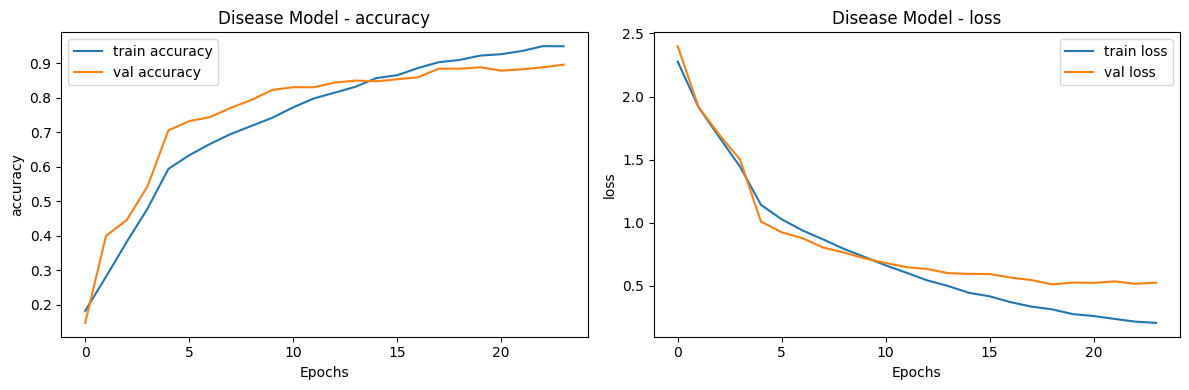

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


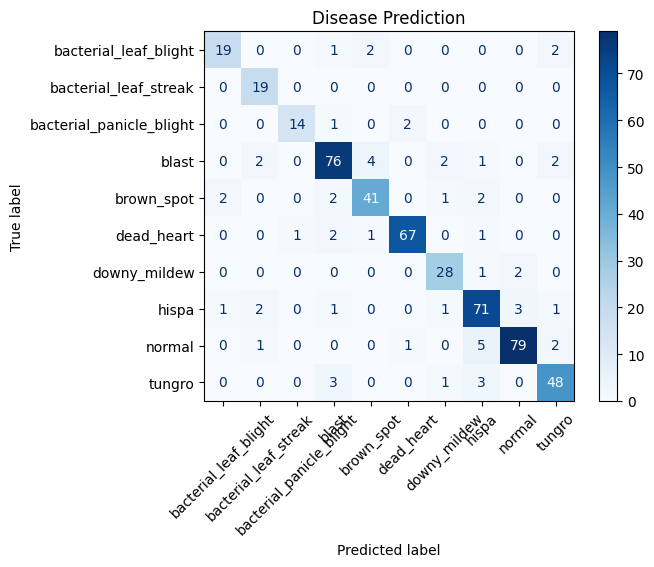

In [222]:
# Evaluate and Plot: Disease Model
history_disease = model_disease.history
plot_training_history(history_disease, "Disease Model")

y_d_pred = np.argmax(model_disease.predict(X_d_test), axis=1)
plot_confusion_matrix(y_d_test, y_d_pred, class_names=disease_encoder.classes_, title="Disease Prediction")

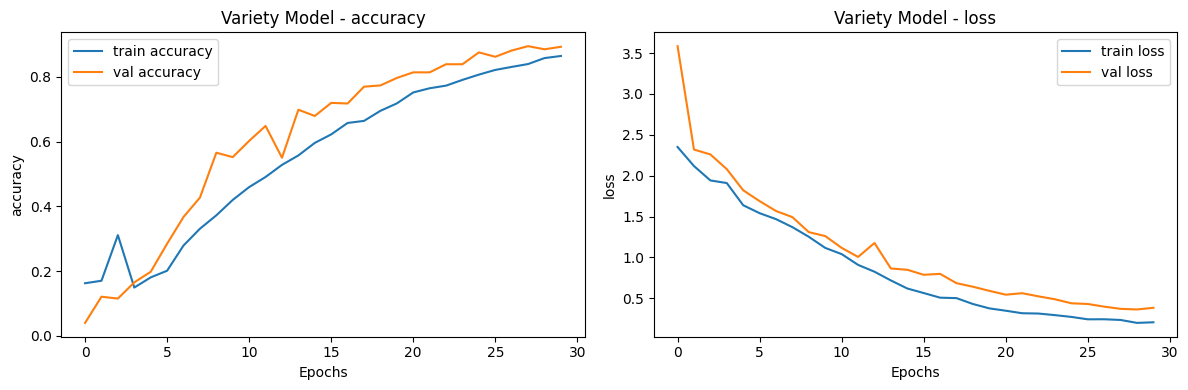

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


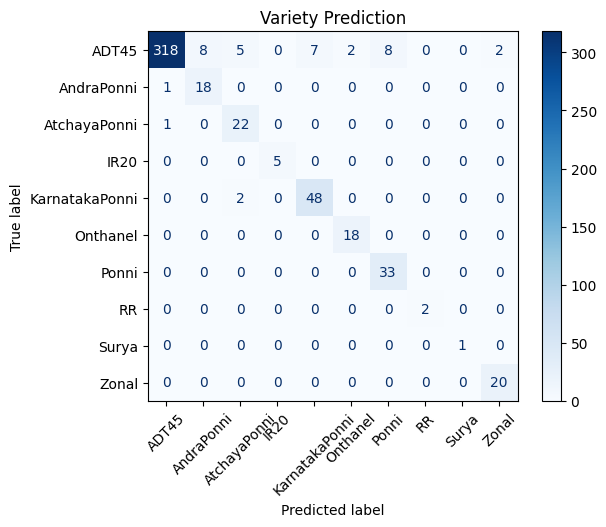

In [223]:
# Evaluate and Plot: Variety Model
history_variety = model_variety.history
plot_training_history(history_variety, "Variety Model")

y_v_pred = np.argmax(model_variety.predict(X_v_test), axis=1)
plot_confusion_matrix(y_v_test, y_v_pred, class_names=variety_encoder.classes_, title="Variety Prediction")

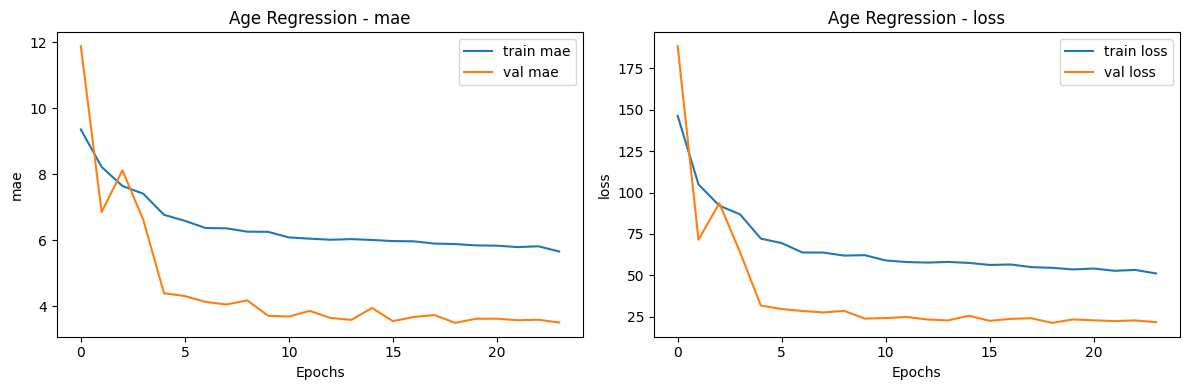

In [224]:
# Evaluate and Plot: Age Model
history_age = model_age.history
plot_training_history(history_age, "Age Regression", metrics=['mae', 'loss'])

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


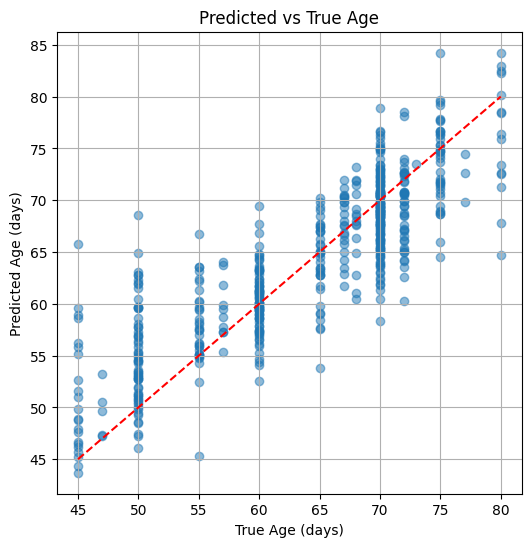

In [225]:
# Plot predicted vs true age
y_a_pred = model_age.predict(X_a_test).flatten()
plt.figure(figsize=(6, 6))
plt.scatter(y_a_test, y_a_pred, alpha=0.5)
plt.plot([min(y_a_test), max(y_a_test)], [min(y_a_test), max(y_a_test)], 'r--')
plt.xlabel("True Age (days)")
plt.ylabel("Predicted Age (days)")
plt.title("Predicted vs True Age")
plt.grid(True)
plt.show()

### Testing the model with test set

#### Test: Disease label model

In [226]:
print("🔬 Disease Classification Test Evaluation")
disease_preds = model_disease.predict(X_d_test)
disease_preds_labels = np.argmax(disease_preds, axis=1)

print(classification_report(y_d_test, disease_preds_labels, target_names=disease_encoder.classes_))

🔬 Disease Classification Test Evaluation
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.86      0.79      0.83        24
   bacterial_leaf_streak       0.79      1.00      0.88        19
bacterial_panicle_blight       0.93      0.82      0.87        17
                   blast       0.88      0.87      0.88        87
              brown_spot       0.85      0.85      0.85        48
              dead_heart       0.96      0.93      0.94        72
            downy_mildew       0.85      0.90      0.88        31
                   hispa       0.85      0.89      0.87        80
                  normal       0.94      0.90      0.92        88
                  tungro       0.87      0.87      0.87        55

                accuracy                           0.89       521
               macro avg       0.88      0.88      0.88       521
            weighted avg       0.89      0.89      0.89     

#### Test: Variety model

In [227]:
print("🔬 Variety Classification Test Evaluation")
variety_preds = model_variety.predict(X_v_test)
variety_preds_labels = np.argmax(variety_preds, axis=1)

print(classification_report(y_v_test, variety_preds_labels, target_names=variety_encoder.classes_))

🔬 Variety Classification Test Evaluation
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
                precision    recall  f1-score   support

         ADT45       0.99      0.91      0.95       350
    AndraPonni       0.69      0.95      0.80        19
  AtchayaPonni       0.76      0.96      0.85        23
          IR20       1.00      1.00      1.00         5
KarnatakaPonni       0.87      0.96      0.91        50
      Onthanel       0.90      1.00      0.95        18
         Ponni       0.80      1.00      0.89        33
            RR       1.00      1.00      1.00         2
         Surya       1.00      1.00      1.00         1
         Zonal       0.91      1.00      0.95        20

      accuracy                           0.93       521
     macro avg       0.89      0.98      0.93       521
  weighted avg       0.94      0.93      0.93       521



#### Test: Age regression model

In [228]:
print("🔬 Age Regression Test Evaluation")
age_preds = model_age.predict(X_a_test).flatten()

mae = mean_absolute_error(y_a_test, age_preds)
rmse = np.sqrt(mean_squared_error(y_a_test, age_preds))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

🔬 Age Regression Test Evaluation
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Mean Absolute Error (MAE): 3.51
Root Mean Squared Error (RMSE): 4.73


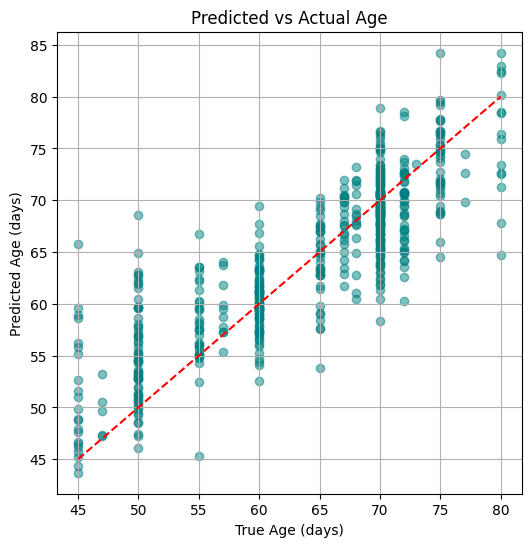

In [229]:
# Predicted vs actual age testing set
plt.figure(figsize=(6, 6))
plt.scatter(y_a_test, age_preds, alpha=0.5, color='teal')
plt.plot([min(y_a_test), max(y_a_test)], [min(y_a_test), max(y_a_test)], 'r--')
plt.title("Predicted vs Actual Age")
plt.xlabel("True Age (days)")
plt.ylabel("Predicted Age (days)")
plt.grid(True)
plt.show()

## Save models

In [230]:
os.makedirs("saved_models", exist_ok=True)

# Save each model
model_disease.save("saved_models/model_disease.keras")
model_variety.save("saved_models/model_variety.keras")
model_age.save("saved_models/model_age.keras")

#### Save label encoders for prediction

In [231]:
import pickle

# Save Label Encoders
os.makedirs("saved_models", exist_ok=True)  # Ensure the directory exists

# Save disease encoder
with open("saved_models/label_encoder_disease.pkl", "wb") as f:
    pickle.dump(disease_encoder, f)

# Save variety encoder
with open("saved_models/label_encoder_variety.pkl", "wb") as f:
    pickle.dump(variety_encoder, f)

print("Label encoders saved to 'saved_models/'")

Label encoders saved to 'saved_models/'


## Load models and predict

In [27]:
# Kaggle specific file path
KAGGLE_OUT = ''

In [29]:
from tensorflow.keras.models import load_model
import os
import pickle

# Load models and encoders
model_disease_pred = load_model(os.path.join(KAGGLE_OUT, "app/saved_models/model_disease.keras"))
model_variety_pred = load_model(os.path.join(KAGGLE_OUT, "app/saved_models/model_variety.keras"))
model_age_pred = load_model(os.path.join(KAGGLE_OUT, "app/saved_models/model_age.keras"))

with open(os.path.join(KAGGLE_OUT, "app/saved_models/label_encoder_disease.pkl"), "rb") as f:
    disease_encoder_pred = pickle.load(f)

with open(os.path.join(KAGGLE_OUT, "app/saved_models/label_encoder_variety.pkl"), "rb") as f:
    variety_encoder_pred = pickle.load(f)

#### Load test images files

In [32]:
test_dir = os.path.join("test_images")
image_files = sorted([
    f for f in os.listdir(test_dir)
    if f.lower().endswith(('.jpg', '.jpeg', '.png')) and not f.startswith('.')
])

#### Preprocess images

In [33]:
def preprocess_image(filepath, target_size=(128, 128)):
    img = load_img(filepath, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # normalize
    return img_array

images = []
image_ids = []

for filename in image_files:
    path = os.path.join(test_dir, filename)
    img_array = preprocess_image(path)
    images.append(img_array)
    image_ids.append(filename)

X_predict = np.array(images)
print(f'{len(X_predict)} images loaded')

3469 images loaded


#### Predict

In [34]:
disease_preds = model_disease_pred.predict(X_predict)
variety_preds = model_variety_pred.predict(X_predict)
age_preds = model_age_pred.predict(X_predict).flatten()

disease_labels = disease_encoder_pred.inverse_transform(np.argmax(disease_preds, axis=1))
variety_labels = variety_encoder_pred.inverse_transform(np.argmax(variety_preds, axis=1))

109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step


#### Create prediction dataframe

In [37]:
submission_df = pd.DataFrame({
    "image_id": image_ids,
    "label": disease_labels,
    "variety": variety_labels,
    "age": age_preds.round().astype(int)  # Round and convert to int
})

In [38]:
# Save to CSV
submission_df.to_csv("test_predictions_1.csv", index=False)
print("Predictions saved to 'test_predictions_1.csv'")

Predictions saved to 'test_predictions_1.csv'
